In [1]:
import os
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy

%matplotlib inline

# Abstract

Imagine that an automobile manufacturer has developed prototypes for a new vehicle. Before introducing the new model into its range, the manufacturer wants to determine which existing vehicles on the market are most like the prototypes--that is, how vehicles can be grouped, which group is the most similar with the model, and therefore which models they will be competing against.

Our objective here, is to use clustering methods, to find the most distinctive clusters of vehicles. It will summarize the existing vehicles and help manufacturers to make decision about the supply of new models.

Source: IBM lab from AI engineering specialization.

# Download data

In [2]:
DOWNLOAD_ROOT = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/"
DATASETS_PATH = os.path.join("Datasets")
FILENAME = "cars_clus.csv"

def fetch_data():    
    if not os.path.isdir(DATASETS_PATH):
        os.makedirs(DATASETS_PATH)
    csv_path = os.path.join(DATASETS_PATH, FILENAME) 
    urllib.request.urlretrieve(DOWNLOAD_ROOT + FILENAME, csv_path)
        
def load_data():
    csv_path = os.path.join(DATASETS_PATH, FILENAME) 
    return pd.read_csv(csv_path)

In [3]:
fetch_data()
df = load_data()

# Inspecting data

In [4]:
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
manufact     157 non-null object
model        159 non-null object
sales        159 non-null object
resale       159 non-null object
type         159 non-null object
price        159 non-null object
engine_s     159 non-null object
horsepow     159 non-null object
wheelbas     159 non-null object
width        159 non-null object
length       159 non-null object
curb_wgt     159 non-null object
fuel_cap     159 non-null object
mpg          159 non-null object
lnsales      159 non-null object
partition    159 non-null float64
dtypes: float64(1), object(15)
memory usage: 10.6+ KB


All columns are objects. Lets convert numerical of them into numeric type

In [6]:
def convert_to_numeric(df):
    df[['sales', 'resale', 'type', 
        'price', 'engine_s', 'horsepow', 'wheelbas', 'width', 
        'length', 'curb_wgt', 'fuel_cap', 'mpg', 'lnsales', 
        'partition']] = df[['sales', 'resale', 'type', 
        'price', 'engine_s', 'horsepow', 'wheelbas', 'width', 
        'length', 'curb_wgt', 'fuel_cap', 'mpg', 'lnsales', 
        'partition']].apply(pd.to_numeric, errors='coerce')
    return df

In [7]:
df = convert_to_numeric(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
manufact     157 non-null object
model        159 non-null object
sales        157 non-null float64
resale       121 non-null float64
type         157 non-null float64
price        157 non-null float64
engine_s     158 non-null float64
horsepow     158 non-null float64
wheelbas     158 non-null float64
width        158 non-null float64
length       158 non-null float64
curb_wgt     157 non-null float64
fuel_cap     158 non-null float64
mpg          156 non-null float64
lnsales      157 non-null float64
partition    159 non-null float64
dtypes: float64(14), object(2)
memory usage: 18.7+ KB


Looks better.

Still, there are lots of null values

In [8]:
df = df.dropna().reset_index(drop=True)

In [9]:
featureset = df[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]
featureset.head()

,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg
0,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0
1,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0
2,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0
3,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0
4,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0


In [10]:
featureset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 8 columns):
engine_s    117 non-null float64
horsepow    117 non-null float64
wheelbas    117 non-null float64
width       117 non-null float64
length      117 non-null float64
curb_wgt    117 non-null float64
fuel_cap    117 non-null float64
mpg         117 non-null float64
dtypes: float64(8)
memory usage: 7.4 KB


# Pipeline

In [11]:
class FeatureSelecter(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X[self.attribute_names]        
        return X.values


In [12]:
preprocess_pipeline = Pipeline([
    ('preprocess', FeatureSelecter(['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg'])),
    ('scaler', MinMaxScaler())
])

# Visualizing clusters

In [13]:
X = preprocess_pipeline.fit_transform(df)

In [14]:
distances = distance_matrix(X, X) 
linkage_matrix = hierarchy.linkage(distances, method='complete')

c:\users\batyr\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


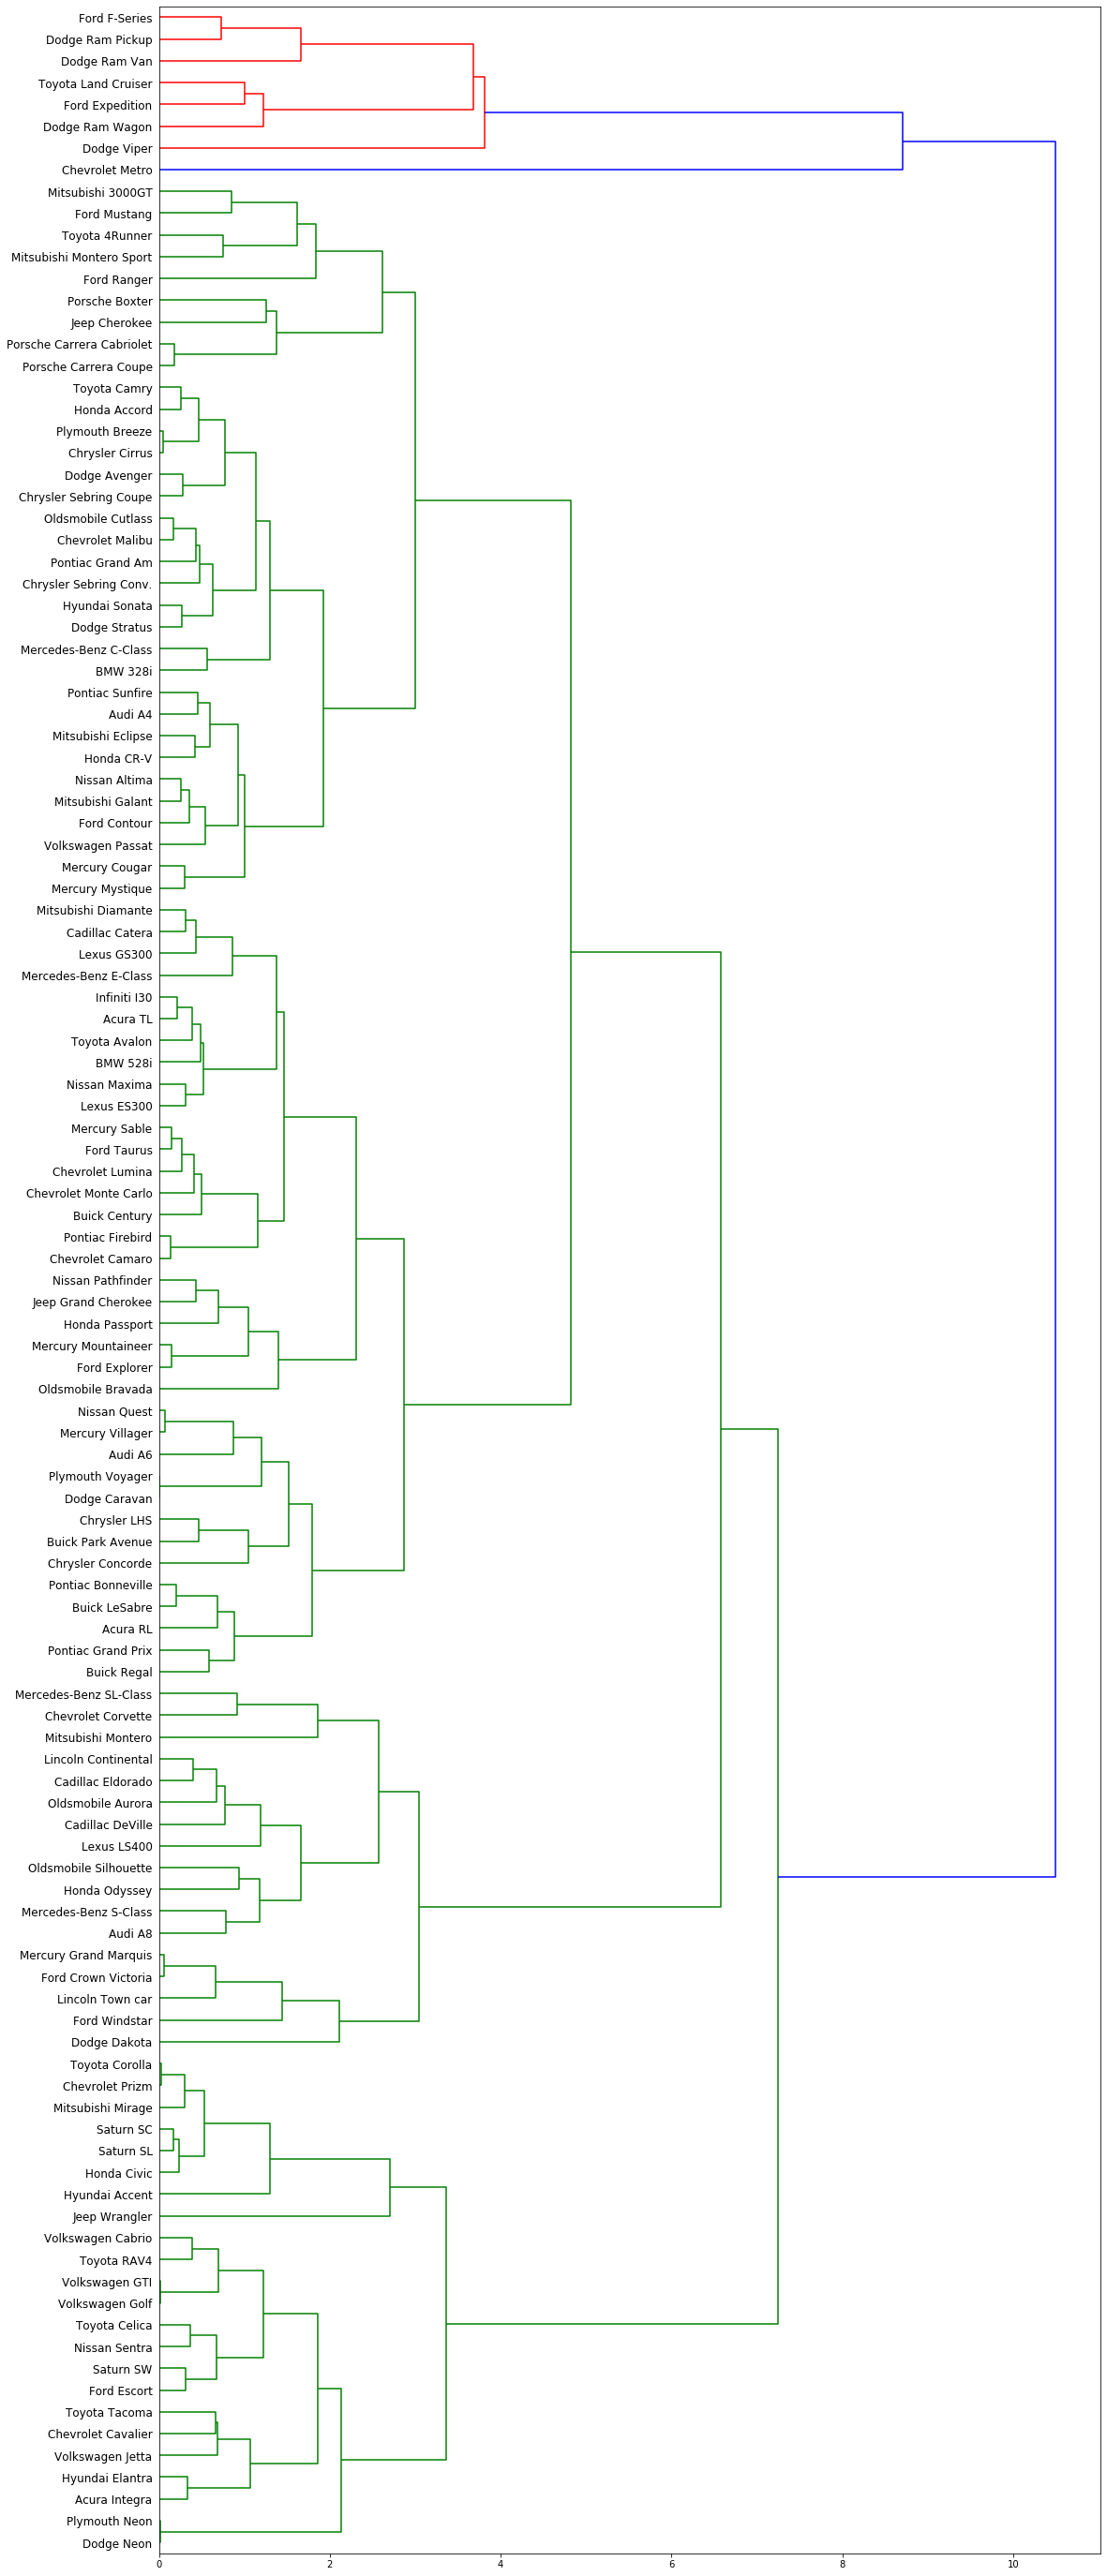

In [20]:
plt.figure(figsize=(18,50))

def llf(id):
    return '{} {}'.format(df['manufact'][id], df['model'][id])

dendro = hierarchy.dendrogram(linkage_matrix, leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')
plt.savefig('dendro.png')

# Reviewing results

I selectively checked some clusters on google images. Grouped cars looks similar   

Let's see parameters too:

In [35]:
df[(df['manufact'] == 'Plymouth')&(df['model'] == 'Neon') | (df['manufact'] == 'Dodge')&(df['model'] == 'Neon')]

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
28,Dodge,Neon,76.034,7.75,0.0,12.64,2.0,132.0,105.0,74.4,174.4,2.567,12.5,29.0,4.331,0.0
90,Plymouth,Neon,32.734,7.75,0.0,12.64,2.0,132.0,105.0,74.4,174.4,2.559,12.5,29.0,3.488,0.0


Pretty good. Let's check clusters on the higher lvl:

In [36]:
df[(df['manufact'] == 'Pontiac')&(df['model'] == 'Bonneville') | (df['manufact'] == 'Acura')&(df['model'] == 'RL')]

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
2,Acura,RL,8.588,29.725,0.0,42.000,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.150,0.0
97,Pontiac,Bonneville,35.945,13.225,0.0,23.755,3.8,205.0,112.2,72.6,202.5,3.59,17.5,24.0,3.582,0.0


These two are grouped on the second layer but difference in price is x2. May be Acura is an expensive brand?

I will check another Acura's model with clustered one:

In [42]:
df[(df['manufact'] == 'Infiniti')&(df['model'] == 'I30') | (df['manufact'] == 'Acura')&(df['model'] == 'TL')]

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
1,Acura,TL,39.384,19.875,0.0,28.400,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
55,Infiniti,I30,23.713,19.690,0.0,29.465,3.0,227.0,108.3,70.2,193.7,3.342,18.5,25.0,3.166,0.0


Price is equal. Great!